visualize Multi layer attentions

In [7]:
from transformers import GPT2Model, GPT2Tokenizer
import torch
from bertviz import model_view

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2', output_attentions=True)

inputs = tokenizer.encode("write a love letter to another computer", return_tensors='pt')

outputs = model(inputs)
attentions = outputs.attentions

tokens = tokenizer.convert_ids_to_tokens(inputs[0])

# Use bertviz to visualize attentions
model_view(attentions, tokens)


<IPython.core.display.Javascript object>

In [3]:
from transformers import GPT2Tokenizer, GPT2Model
from bertviz import head_view
import torch

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2', output_attentions=True)

inputs = tokenizer.encode("The quick brown fox jumps over the lazy dog", return_tensors='pt')
outputs = model(inputs)
attentions = outputs.attentions

input_tokens = tokenizer.convert_ids_to_tokens(inputs[0])

# Visualization with bertviz
head_view(attentions, input_tokens)


<IPython.core.display.Javascript object>

node based graph

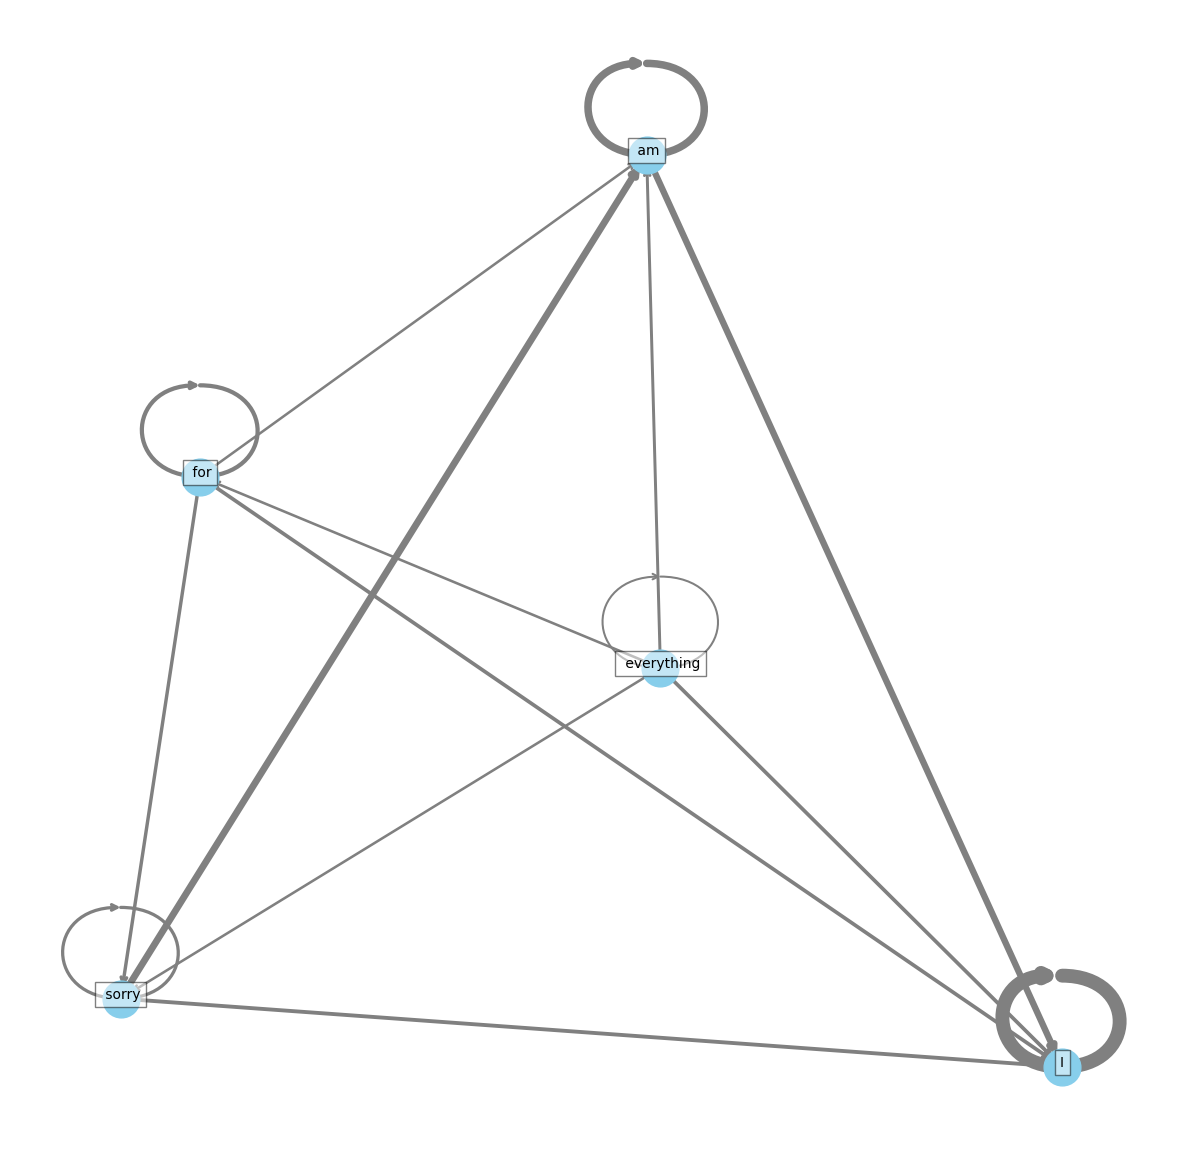

In [2]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2Model.from_pretrained('gpt2', output_attentions=True)

text = "I am sorry for everything"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions

# last layer and the first head for visualization
attention_matrix = attentions[-1][0][0].detach().numpy()

tokens = tokenizer.tokenize(text)
clean_tokens = [token.replace("Ġ", " ") for token in tokens]  

G = nx.DiGraph()

for i, token in enumerate(clean_tokens):
    G.add_node(i, label=token)

threshold = 0.01  
for i in range(len(clean_tokens)):
    for j in range(len(clean_tokens)):
        weight = attention_matrix[i][j]
        if weight > threshold:
            G.add_edge(i, j, weight=weight)

pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(15, 15))  
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue")

for i, token in enumerate(clean_tokens):
    x, y = pos[i]
    plt.text(x, y, s=token, bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')

edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle="->", arrowsize=10, 
                       width=[d['weight']*10 for (u, v, d) in edges], edge_color="grey")

plt.axis('off')
plt.show()


Topic Modeling

Latent Dirichlet Allocation (LDA) 

In [6]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim import corpora, models
import re

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    sentences = sent_tokenize(text)
    words = [word_tokenize(re.sub(r'[^a-zA-Z]', ' ', sentence.lower())) for sentence in sentences]
    words = [[word for word in tokens if word not in stop_words and len(word) > 1] for tokens in words]
    return [word for sublist in words for word in sublist]

# Load letters
folder_path = './samples'  # Update this path
letter_files = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))  
reference_letters = []
for filename in letter_files:
    with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
        reference_letters.append(file.read())

processed_texts = [preprocess_text(letter) for letter in reference_letters]

dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)
def calculate_relevance(generated_text, lda_model, dictionary):
    processed_text = preprocess_text(generated_text)
    bow_vector = dictionary.doc2bow(processed_text)
    lda_vector = lda_model[bow_vector]
    print("LDA Topic Distribution:", lda_vector)
    # Implement your relevance calculation here
    return lda_vector

# Use the function to evaluate a new generated letter
generated_letter = "the Industrial Revolution and its consequences have been a disaster for the human race."
calculate_relevance(generated_letter, lda_model, dictionary)
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Visualize
pyLDAvis.display(vis_data)

# Define the path for the HTML file
output_path = 'lda_visualization.html'

# Save the visualization as an HTML file
pyLDAvis.save_html(vis_data, output_path)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stuxn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stuxn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(0, '0.020*"love" + 0.008*"know" + 0.008*"much" + 0.007*"like" + 0.007*"heart"')
(1, '0.012*"love" + 0.011*"one" + 0.011*"shall" + 0.010*"us" + 0.010*"may"')
(2, '0.016*"love" + 0.009*"said" + 0.008*"see" + 0.007*"heart" + 0.006*"feel"')
(3, '0.017*"love" + 0.007*"us" + 0.007*"shall" + 0.006*"never" + 0.005*"know"')
(4, '0.017*"love" + 0.009*"heart" + 0.007*"would" + 0.007*"one" + 0.007*"letter"')
LDA Topic Distribution: [(0, 0.18839107), (1, 0.40114206), (3, 0.07375775), (4, 0.3283115)]
Visualization saved to c:\Users\stuxn\OneDrive - Goldsmiths College\Desktop\interlingua\lda_visualization.html


Cosine Similarity with TF-IDF Vectors

Total cosine similarity: 15.748512871274642


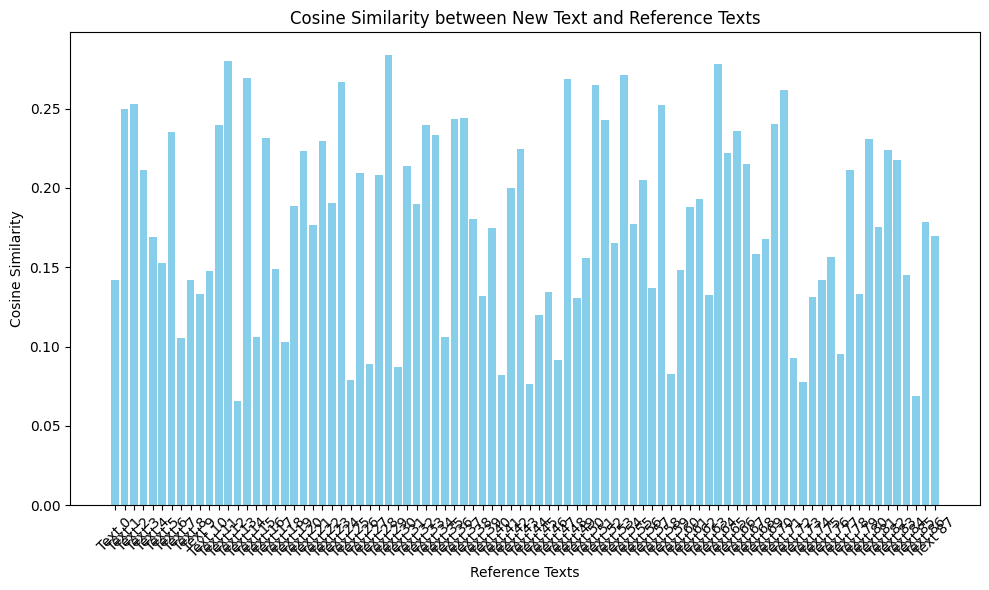

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import numpy as np

def read_texts_from_folder(folder_path):
    texts = []
    file_paths = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))
    for file_name in file_paths:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts

folder_path = './samples' # Update it to new file structre
reference_texts = read_texts_from_folder(folder_path)

new_text = ["a love letter to my beloved sara. I am so happy to have you as my wife. I am very happy that you are here. Thank you for your time and I hope you will continue to be a part of my life."]

all_texts = reference_texts + new_text
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

cosine_similarities = cosine_similarity(tfidf_matrix[-1:], tfidf_matrix[:-1])

# Summing the cosine similarity scores
total_similarity = np.sum(cosine_similarities)
print(f"Total cosine similarity: {total_similarity}")

# Visualizing the cosine similarity scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(reference_texts)), cosine_similarities[0], color='skyblue')
plt.xlabel('Reference Texts')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between New Text and Reference Texts')
plt.xticks(range(len(reference_texts)), labels=[f'Text {i}' for i in range(len(reference_texts))], rotation=45)
plt.tight_layout()
plt.show()



Word Embeddings (Word2Vec)

In [1]:
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import remove_stopwords
import numpy as np
from scipy.spatial.distance import cosine


def glove_to_word2vec(glove_input_file, word2vec_output_file):
    from gensim.scripts.glove2word2vec import glove2word2vec
    glove2word2vec(glove_input_file, word2vec_output_file)

glove_input_file = './glove.6B.100d.txt'
word2vec_output_file = './glove.6B.100d.word2vec.txt'

# Convert
glove_to_word2vec(glove_input_file, word2vec_output_file)
from gensim.models import KeyedVectors

# Now, load it using the word2vec format
model_path = './glove.6B.100d.word2vec.txt'  # Update to the path of the converted model
word_vectors = KeyedVectors.load_word2vec_format(model_path, binary=False)



C:\Users\stuxn\AppData\Local\Temp\ipykernel_23928\291261304.py:9: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


Word2Vec test

In [6]:
import os
import numpy as np
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import remove_stopwords
from scipy.spatial.distance import cosine

def text_to_embedding(text, model):
    words = remove_stopwords(text).lower().split()
    word_vectors = [model[word] for word in words if word in model.key_to_index]
    if not word_vectors:  # Check if word_vectors is empty
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

def cosine_similarity(v1, v2):
    return 1 - cosine(v1, v2)

def evaluate_text_against_threshold(file_path, model, reference_embeddings, threshold=0.1):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    text_embedding = text_to_embedding(text, model)
    similarities = [cosine_similarity(text_embedding, ref_emb) for ref_emb in reference_embeddings]
    average_similarity = np.mean(similarities)
    classification = 'True' if average_similarity >= threshold else 'False'
    print(f"File '{os.path.basename(file_path)}': Average Similarity = {average_similarity:.4f} -> {classification}")

def read_texts_from_folder(folder_path):
    texts = []
    for filename in sorted(os.listdir(folder_path), key=lambda x: os.path.getmtime(os.path.join(folder_path, x))):
        filepath = os.path.join(folder_path, filename)
        with open(filepath, 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts

from gensim.models import KeyedVectors

model_path = './glove.6B.100d.word2vec.txt'  # Update to new files
word_vectors = KeyedVectors.load_word2vec_format(model_path, binary=False)


reference_folder = './true'  # Update 
reference_texts = read_texts_from_folder(reference_folder)
reference_embeddings = np.array([text_to_embedding(text, word_vectors) for text in reference_texts])

# Evaluate new texts
folder_to_evaluate = './false'  # Updat
files_to_evaluate = [os.path.join(folder_to_evaluate, f) for f in os.listdir(folder_to_evaluate) if f.endswith('.txt')]

for file_path in files_to_evaluate:
    evaluate_text_against_threshold(file_path, word_vectors, reference_embeddings)


File 'false1.txt': Average Similarity = 0.9333 -> True
File 'false10.txt': Average Similarity = 0.9297 -> True
File 'false11.txt': Average Similarity = 0.9340 -> True
File 'false12.txt': Average Similarity = 0.9256 -> True
File 'false13.txt': Average Similarity = 0.9310 -> True
File 'false14.txt': Average Similarity = 0.9307 -> True
File 'false15.txt': Average Similarity = 0.9312 -> True
File 'false16.txt': Average Similarity = 0.9334 -> True
File 'false17.txt': Average Similarity = 0.9351 -> True
File 'false18.txt': Average Similarity = 0.9300 -> True
File 'false19.txt': Average Similarity = 0.9360 -> True
File 'false2.txt': Average Similarity = 0.9310 -> True
File 'false20.txt': Average Similarity = 0.9327 -> True
File 'false21.txt': Average Similarity = 0.9343 -> True
File 'false22.txt': Average Similarity = 0.9322 -> True
File 'false23.txt': Average Similarity = 0.9219 -> True
File 'false24.txt': Average Similarity = 0.9297 -> True
File 'false25.txt': Average Similarity = 0.9316 ->

BERT

In [7]:
import os

def read_texts_from_folder(folder_path):
    texts = []
    for filename in sorted(os.listdir(folder_path), key=lambda x: os.path.getmtime(os.path.join(folder_path, x))):
        filepath = os.path.join(folder_path, filename)
        with open(filepath, 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts

reference_folder = './true'  # Update
reference_texts = read_texts_from_folder(reference_folder)


In [10]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def text_to_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        # reducing to a 1D vector (shape should be [embedding_dim])
        embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    # Convert to numpy and squeeze to 1D
    return embeddings.squeeze().numpy()

from scipy.spatial.distance import cosine

def calculate_similarity(embedding1, embedding2):
    # make sure both embeddings are numpy arrays and 1-D
    embedding1 = np.asarray(embedding1).squeeze()
    embedding2 = np.asarray(embedding2).squeeze()
    
    #  perform cosine similarity
    return 1 - cosine(embedding1, embedding2)

reference_embeddings = [text_to_embedding(text, tokenizer, model) for text in reference_texts]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
import numpy as np  # Make sure numpy is imported correctly

def evaluate_texts(folder_path, reference_embeddings, tokenizer, model, threshold=0.78):
    new_texts = read_texts_from_folder(folder_path)
    for text in new_texts:
        new_embedding = text_to_embedding(text, tokenizer, model)
        similarities = [calculate_similarity(new_embedding, ref_emb) for ref_emb in reference_embeddings]
        avg_similarity = np.mean(similarities)
        classification = 'True' if avg_similarity >= threshold else 'False'
        print(f"Text: Average Similarity = {avg_similarity:.4f} -> Classified as {classification}")




t-sne for bert

[t-SNE] Computing 90 nearest neighbors...
[t-SNE] Indexed 91 samples in 0.000s...
[t-SNE] Computed neighbors for 91 samples in 0.183s...
[t-SNE] Computed conditional probabilities for sample 91 / 91
[t-SNE] Mean sigma: 1.448263
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.561260
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


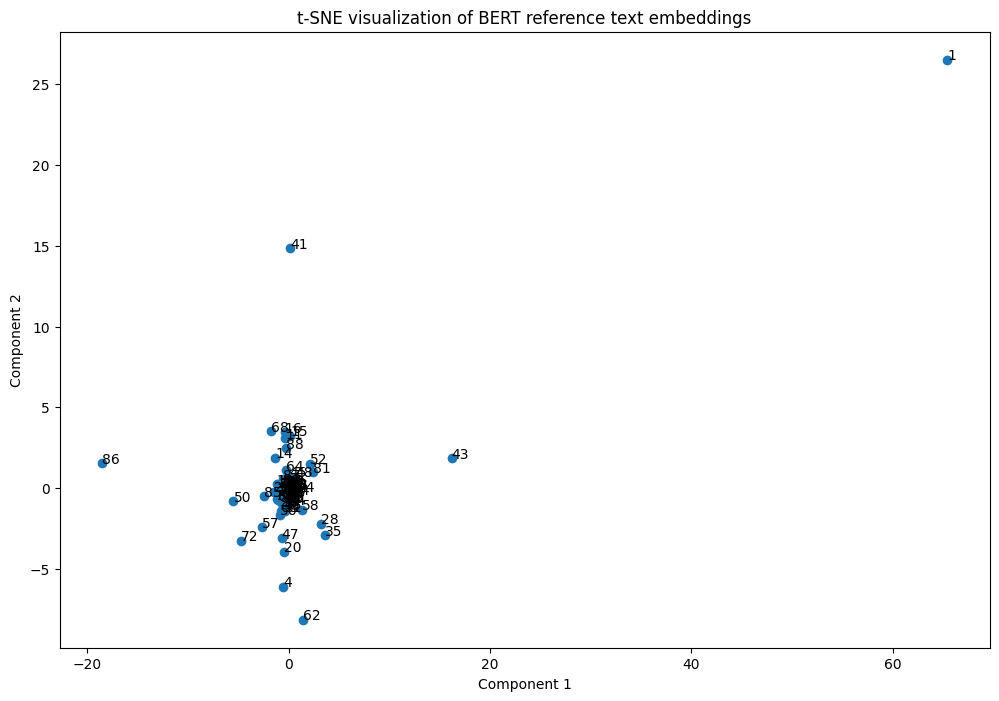

In [17]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embeddings_matrix = np.vstack(reference_embeddings)

# Initialize and fit t-SNE, reducing to two components for 2D visualization
tsne_model = TSNE(n_components=2, random_state=42, n_iter=250, verbose=1)
tsne_embeddings = tsne_model.fit_transform(embeddings_matrix)

# Plotting the results of t-SNE
plt.figure(figsize=(12, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])

for i, txt in enumerate(range(len(reference_texts))):
    plt.annotate(txt, (tsne_embeddings[i, 0], tsne_embeddings[i, 1]))

plt.title('t-SNE visualization of BERT reference text embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


heatmap

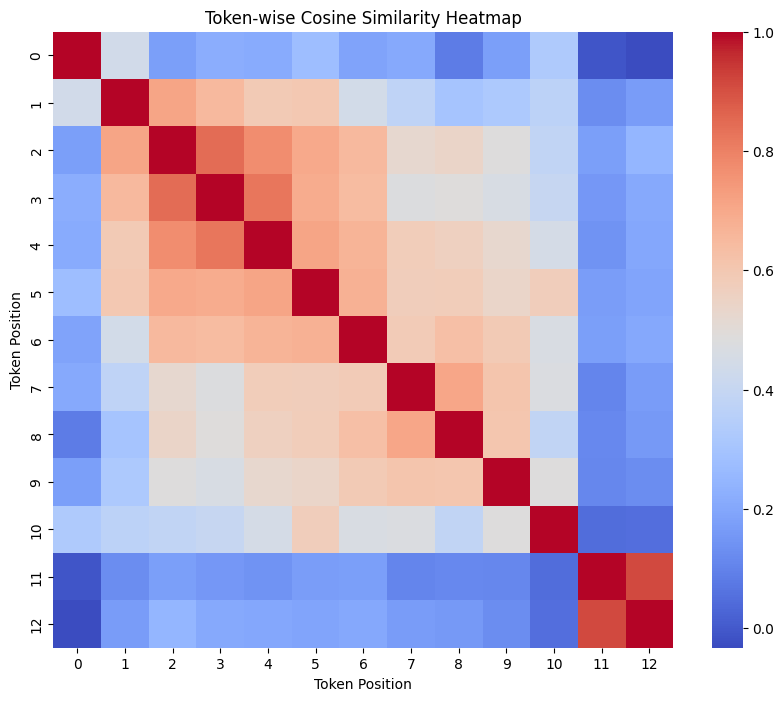

In [21]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(model, tokenizer, text):
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        # Use the last layer's hidden state
        embeddings = outputs.last_hidden_state
        embeddings = embeddings.squeeze(0)  # Remove batch dimension

    # Calculate cosine similarity
    similarities = torch.mm(embeddings, embeddings.transpose(0, 1)) / (torch.norm(embeddings, dim=1).reshape(-1, 1) * torch.norm(embeddings, dim=1))

    # Convert to numpy
    similarities = similarities.numpy()

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarities, annot=False, cmap='coolwarm', cbar=True)
    plt.title("Token-wise Cosine Similarity Heatmap")
    plt.xlabel("Token Position")
    plt.ylabel("Token Position")
    plt.show()

# Example 
text = "Here is some example text to visualize with BERT."
plot_heatmap(model, tokenizer, text)


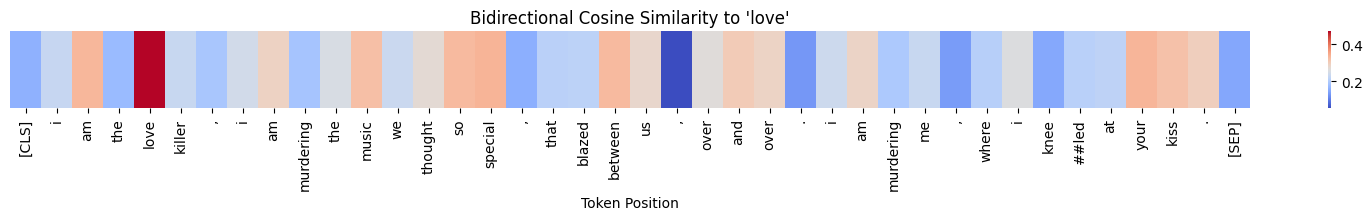

In [28]:
def plot_similarity_to_word_with_labels(model, tokenizer, text, word='love'):
    text_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    word_inputs = tokenizer(word, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        text_outputs = model(**text_inputs)
        word_outputs = model(**word_inputs)
        
        # take first token after [CLS]
        text_embeddings = text_outputs.last_hidden_state
        word_embedding = word_outputs.last_hidden_state[:, 1, :] 

    similarities = torch.nn.functional.cosine_similarity(word_embedding, text_embeddings.squeeze(0), dim=1).numpy()

    tokens = tokenizer.convert_ids_to_tokens(text_inputs['input_ids'].squeeze().tolist())

    
    plt.figure(figsize=(len(tokens) * 0.5, 1))  
    ax = sns.heatmap([similarities], annot=False, cmap='coolwarm', cbar=True, xticklabels=tokens)
    ax.set_title(f"Bidirectional Cosine Similarity to '{word}'")
    ax.set_xlabel("Token Position")
    plt.xticks(rotation=90)  # Rotate tokens for better visibility
    plt.yticks([])  # Hide y-axis ticks
    plt.show()

text = "I am the love killer, I am murdering the music we thought so special,that blazed between us, over and over. I am murdering me, where I kneeled at your kiss."
plot_similarity_to_word_with_labels(model, tokenizer, text, word='love')



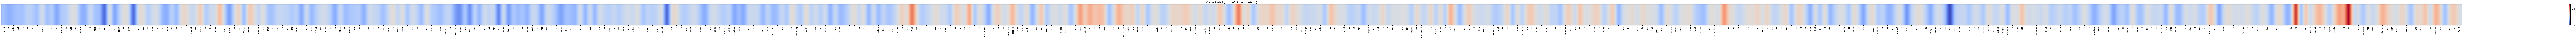

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_smooth_similarity_heatmap(model, tokenizer, text, word='love'):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    word_inputs = tokenizer(word, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        text_outputs = model(**inputs)
        word_outputs = model(**word_inputs)
        
        text_embeddings = text_outputs.last_hidden_state.squeeze(0) 
        word_embedding = word_outputs.last_hidden_state[:, 1, :].squeeze(0)  
        
    similarities = torch.nn.functional.cosine_similarity(word_embedding.unsqueeze(0), text_embeddings, dim=1).numpy()

    #  smooth heatmap
    fig, ax = plt.subplots(figsize=(len(similarities) * 0.5, 2))  
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().tolist())
    
    cax = ax.imshow(np.array([similarities]), cmap='coolwarm', interpolation='spline16', aspect='auto')
    
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)  
    ax.set_yticks([])  
    
    fig.colorbar(cax, orientation='vertical', fraction=0.046, pad=0.04)
    plt.title(f"Cosine Similarity to '{word}' (Smooth Heatmap)")
    plt.show()

plot_smooth_similarity_heatmap(model, tokenizer, "The rain set early in to-night, The sullen wind was soon awake, It tore the elm-tops down for spite, And did its worst to vex the lake: I listened with heart fit to break. When glided in Porphyria; straight She shut the cold out and the storm, And kneeled and made the cheerless grate Blaze up, and all the cottage warm; Which done, she rose, and from her form Withdrew the dripping cloak and shawl, And laid her soiled gloves by, untied Her hat and let the damp hair fall, And, last, she sat down by my side And called me. When no voice replied, She put my arm about her waist, And made her smooth white shoulder bare, And all her yellow hair displaced, And, stooping, made my cheek lie there, And spread, o'er all, her yellow hair, Murmuring how she loved me---she Too weak, for all her heart's endeavour, To set its struggling passion free From pride, and vainer ties dissever, And give herself to me for ever. But passion sometimes would prevail, Nor could to-night's gay feast restrain A sudden thought of one so pale For love of her, and all in vain: So, she was come through wind and rain. Be sure I looked up at her eyes Happy and proud; at last I knew Porphyria worshipped me; surprise Made my heart swell, and still it grew While I debated what to do. That moment she was mine, mine, fair, Perfectly pure and good: I found A thing to do, and all her hair In one long yellow string I wound Three times her little throat around, And strangled her. No pain felt she; I am quite sure she felt no pain. As a shut bud that holds a bee, I warily oped her lids: again Laughed the blue eyes without a stain. And I untightened next the tress About her neck; her cheek once more Blushed bright beneath my burning kiss: I propped her head up as before, Only, this time my shoulder bore Her head, which droops upon it still: The smiling rosy little head, So glad it has its utmost will, That all it scorned at once is fled, And I, its love, am gained instead! Porphyria's love: she guessed not how Her darling one wish would be heard. And thus we sit together now, And all night long we have not stirred, And yet God has not said a word!", 'love')


2d heatmap

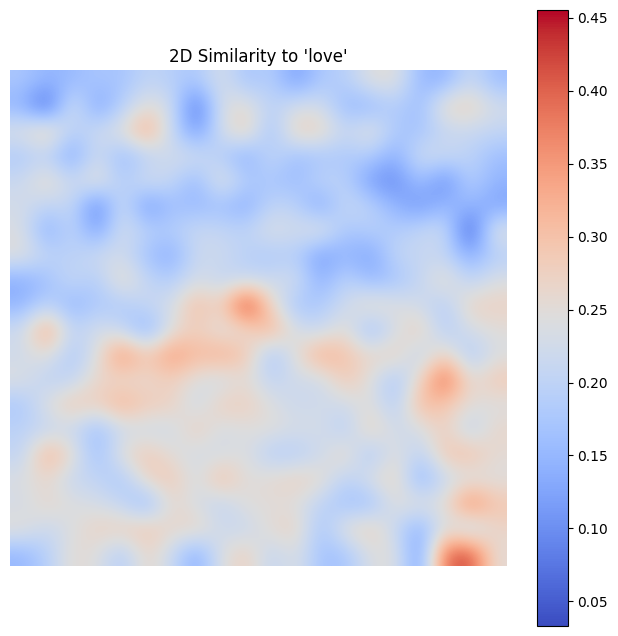

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def text_to_2d_similarity_image(model, tokenizer, text, word='love', grid_size=(50, 50)):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=grid_size[0] * grid_size[1])
    word_inputs = tokenizer(word, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        text_outputs = model(**inputs)
        word_outputs = model(**word_inputs)
        
        text_embeddings = text_outputs.last_hidden_state.squeeze(0)
        word_embedding = word_outputs.last_hidden_state[:, 1, :].squeeze(0)  # Using the first token as the word embedding
    
    similarities = torch.nn.functional.cosine_similarity(word_embedding.unsqueeze(0), text_embeddings, dim=1).numpy()
    
    # Reshape similarities to grid_size
    padded_similarities = np.zeros(grid_size[0] * grid_size[1])
    padded_similarities[:len(similarities)] = similarities
    similarity_matrix = padded_similarities.reshape(grid_size)
    
    
    plt.figure(figsize=(8, 8))
    plt.imshow(similarity_matrix, cmap='coolwarm', interpolation='bicubic')
    plt.colorbar()
    plt.title(f"2D Similarity to '{word}'")
    plt.axis('off')  
    plt.show()

text = "The rain set early in to-night, The sullen wind was soon awake, It tore the elm-tops down for spite, And did its worst to vex the lake: I listened with heart fit to break. When glided in Porphyria; straight She shut the cold out and the storm, And kneeled and made the cheerless grate Blaze up, and all the cottage warm; Which done, she rose, and from her form Withdrew the dripping cloak and shawl, And laid her soiled gloves by, untied Her hat and let the damp hair fall, And, last, she sat down by my side And called me. When no voice replied, She put my arm about her waist, And made her smooth white shoulder bare, And all her yellow hair displaced, And, stooping, made my cheek lie there, And spread, o'er all, her yellow hair, Murmuring how she loved me---she Too weak, for all her heart's endeavour, To set its struggling passion free From pride, and vainer ties dissever, And give herself to me for ever. But passion sometimes would prevail, Nor could to-night's gay feast restrain A sudden thought of one so pale For love of her, and all in vain: So, she was come through wind and rain. Be sure I looked up at her eyes Happy and proud; at last I knew Porphyria worshipped me; surprise Made my heart swell, and still it grew While I debated what to do. That moment she was mine, mine, fair, Perfectly pure and good: I found A thing to do, and all her hair In one long yellow string I wound Three times her little throat around, And strangled her. No pain felt she; I am quite sure she felt no pain. As a shut bud that holds a bee, I warily oped her lids: again Laughed the blue eyes without a stain. And I untightened next the tress About her neck; her cheek once more Blushed bright beneath my burning kiss: I propped her head up as before, Only, this time my shoulder bore Her head, which droops upon it still: The smiling rosy little head, So glad it has its utmost will, That all it scorned at once is fled, And I, its love, am gained instead! Porphyria's love: she guessed not how Her darling one wish would be heard. And thus we sit together now, And all night long we have not stirred, And yet God has not said a word!"
text_to_2d_similarity_image(model, tokenizer, text, word='love', grid_size=(20, 20))


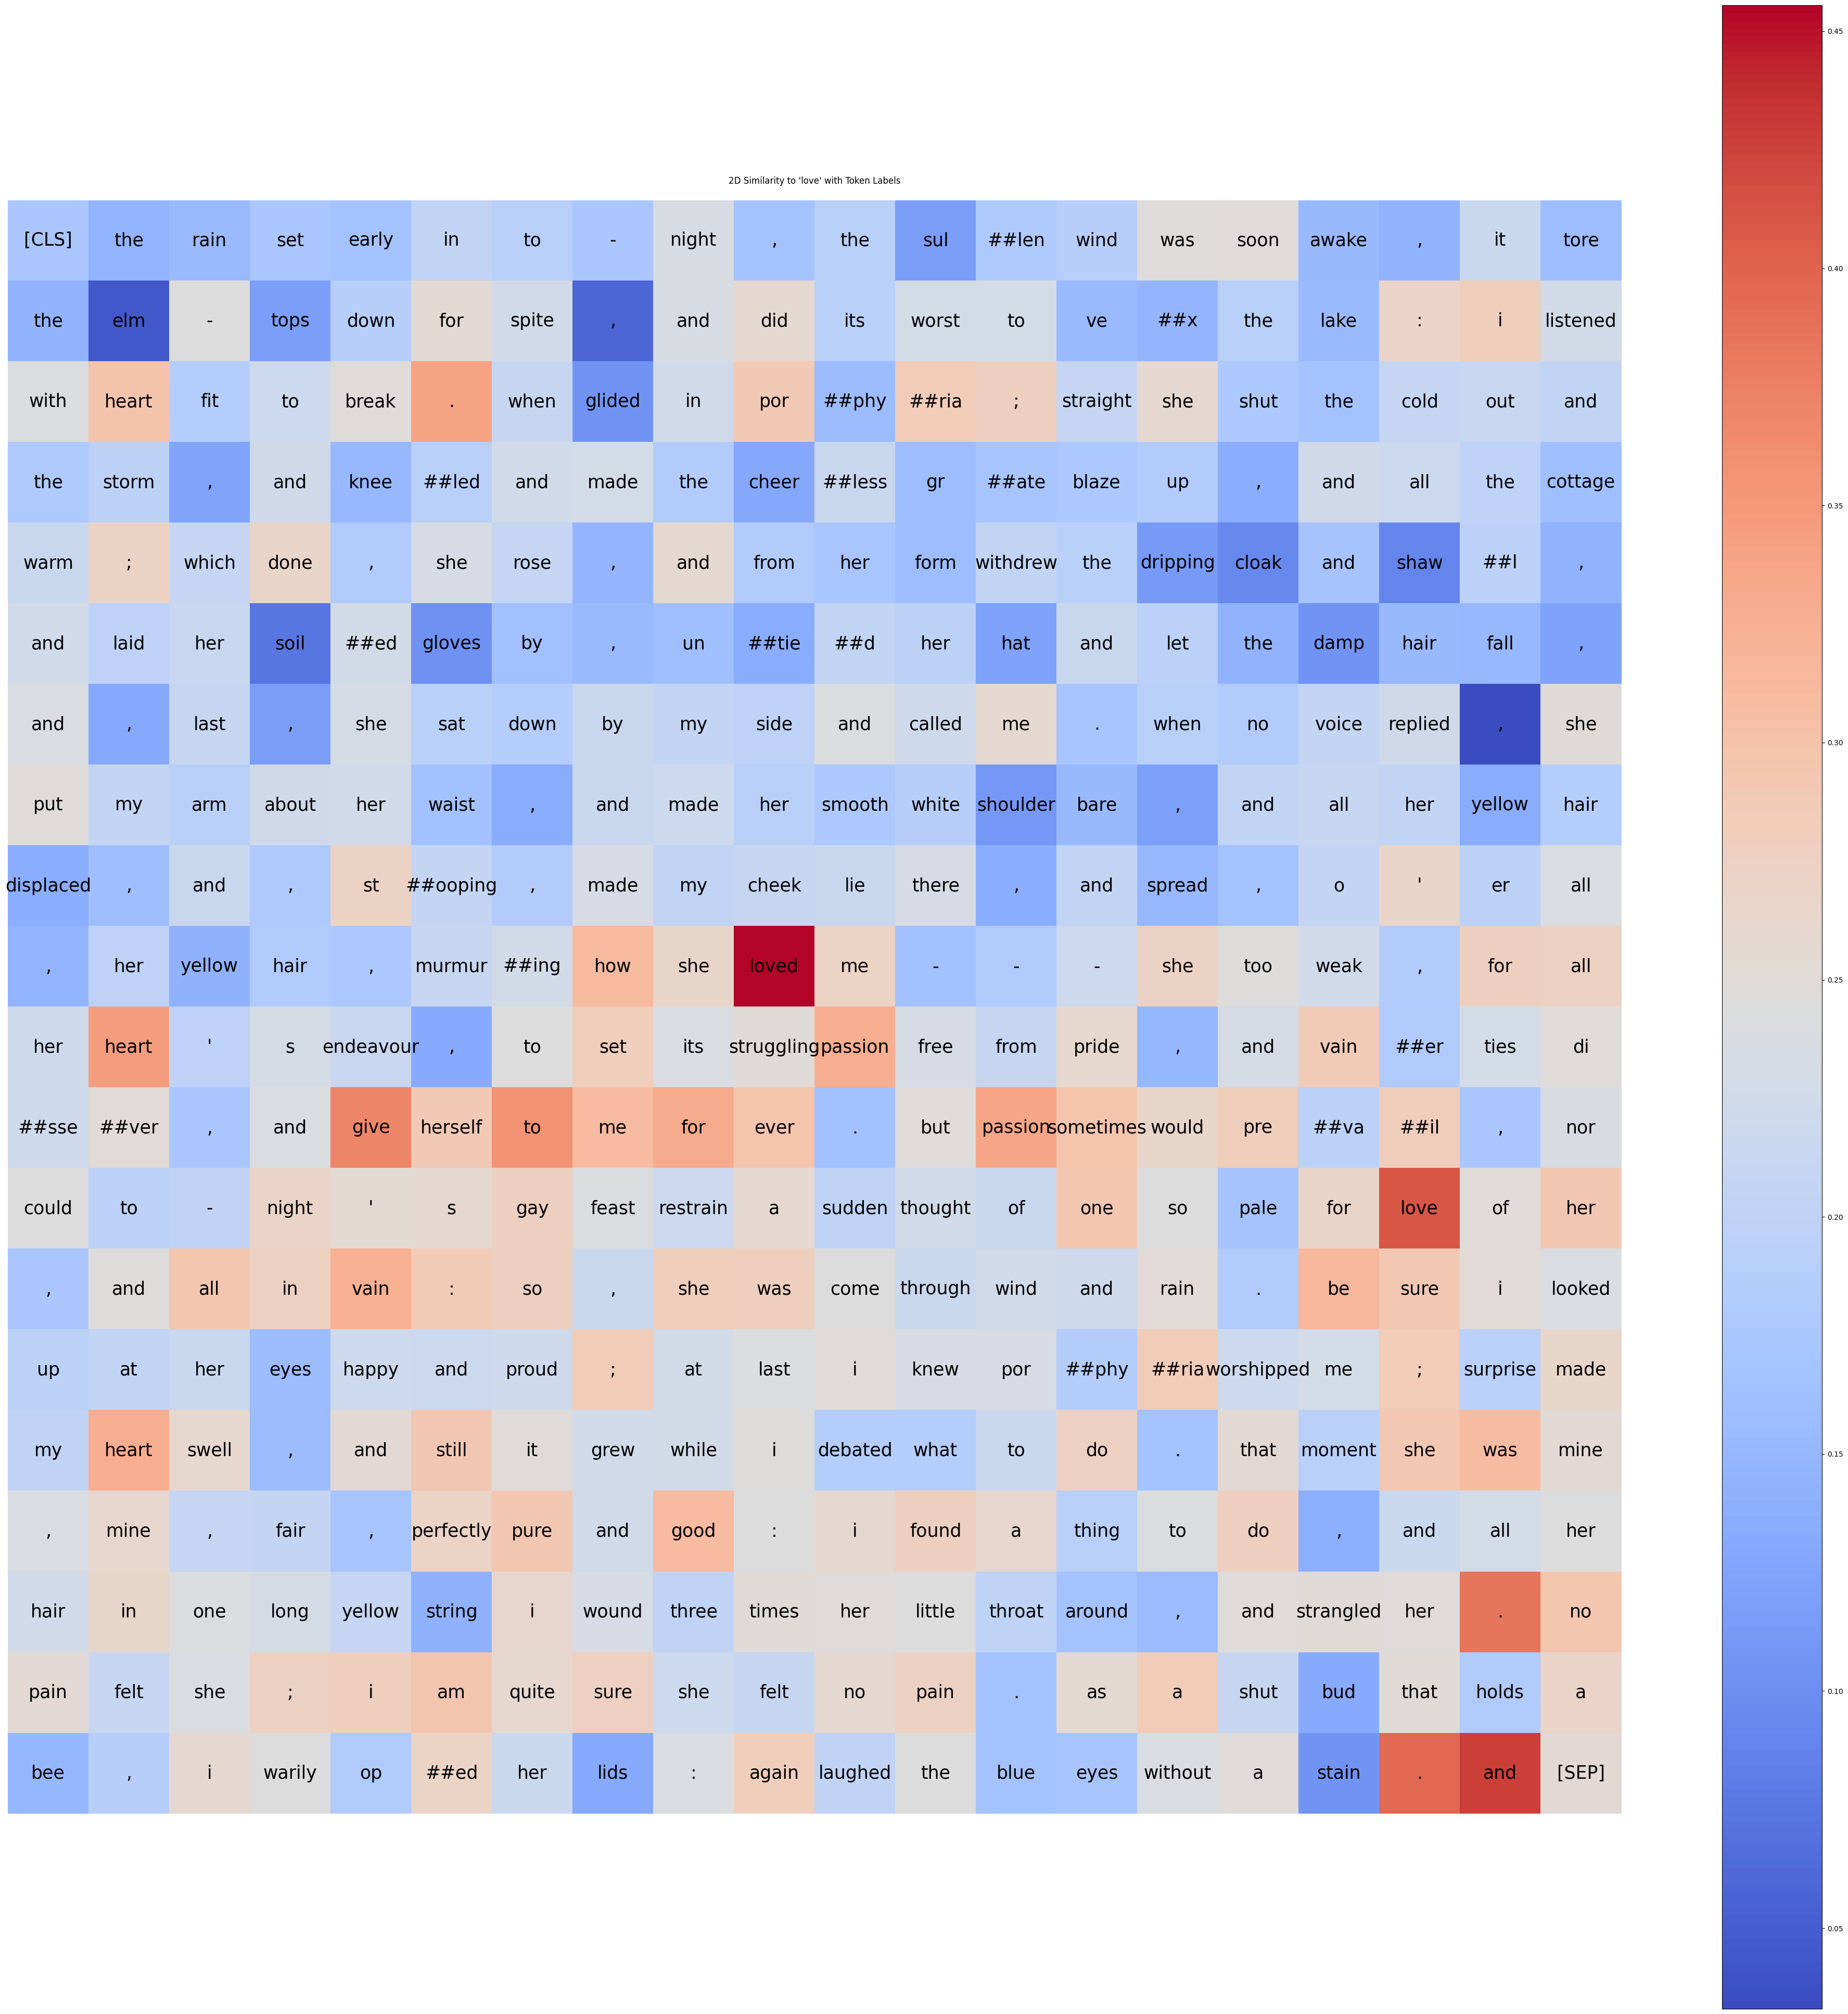

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def text_to_2d_similarity_image_with_labels(model, tokenizer, text, word='love', grid_size=(10, 10)):

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=grid_size[0] * grid_size[1])
    word_inputs = tokenizer(word, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        text_outputs = model(**inputs)
        word_outputs = model(**word_inputs)
        
        text_embeddings = text_outputs.last_hidden_state.squeeze(0)
        word_embedding = word_outputs.last_hidden_state[:, 1, :].squeeze(0)
    
    similarities = torch.nn.functional.cosine_similarity(word_embedding.unsqueeze(0), text_embeddings, dim=1).numpy()
    
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().tolist())
    
    padded_similarities = np.full(grid_size[0] * grid_size[1], fill_value=np.nan)  
    padded_similarities[:len(similarities)] = similarities
    padded_tokens = tokens + [''] * (grid_size[0] * grid_size[1] - len(tokens))
    
    similarity_matrix = padded_similarities.reshape(grid_size)
    token_matrix = np.array(padded_tokens).reshape(grid_size)
    
    fig, ax = plt.subplots(figsize=(50, 50))
    cax = ax.matshow(similarity_matrix, cmap='coolwarm', interpolation='none')
    fig.colorbar(cax)
    
    # Adding text labels to each cell
    for (i, j), token in np.ndenumerate(token_matrix):
        ax.text(j, i, token, ha='center', va='center', color='black', fontsize=25 if grid_size[0] <= 10 else 25)

    plt.title(f"2D Similarity to '{word}' with Token Labels")
    plt.axis('off')
    plt.show()

text = "The rain set early in to-night, The sullen wind was soon awake, It tore the elm-tops down for spite, And did its worst to vex the lake: I listened with heart fit to break. When glided in Porphyria; straight She shut the cold out and the storm, And kneeled and made the cheerless grate Blaze up, and all the cottage warm; Which done, she rose, and from her form Withdrew the dripping cloak and shawl, And laid her soiled gloves by, untied Her hat and let the damp hair fall, And, last, she sat down by my side And called me. When no voice replied, She put my arm about her waist, And made her smooth white shoulder bare, And all her yellow hair displaced, And, stooping, made my cheek lie there, And spread, o'er all, her yellow hair, Murmuring how she loved me---she Too weak, for all her heart's endeavour, To set its struggling passion free From pride, and vainer ties dissever, And give herself to me for ever. But passion sometimes would prevail, Nor could to-night's gay feast restrain A sudden thought of one so pale For love of her, and all in vain: So, she was come through wind and rain. Be sure I looked up at her eyes Happy and proud; at last I knew Porphyria worshipped me; surprise Made my heart swell, and still it grew While I debated what to do. That moment she was mine, mine, fair, Perfectly pure and good: I found A thing to do, and all her hair In one long yellow string I wound Three times her little throat around, And strangled her. No pain felt she; I am quite sure she felt no pain. As a shut bud that holds a bee, I warily oped her lids: again Laughed the blue eyes without a stain. And I untightened next the tress About her neck; her cheek once more Blushed bright beneath my burning kiss: I propped her head up as before, Only, this time my shoulder bore Her head, which droops upon it still: The smiling rosy little head, So glad it has its utmost will, That all it scorned at once is fled, And I, its love, am gained instead! Porphyria's love: she guessed not how Her darling one wish would be heard. And thus we sit together now, And all night long we have not stirred, And yet God has not said a word!"
text_to_2d_similarity_image_with_labels(model, tokenizer, text, word='love', grid_size=(20, 20))
